<a href="https://colab.research.google.com/github/mengwangk/dl-projects/blob/master/number_crunching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Number Crunching

## Magic

In [1]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

In [6]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import pandas as pd
import featuretools as ft
import matplotlib as mpl
import matplotlib.pyplot as plt

In [7]:
from fastai.basics import *
from fastai.tabular import *

In [8]:
# pdb.set_trace

## Setup

In [9]:
# to make this notebook's output stable across runs
np.random.seed(42)

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

from IPython.display import display
pd.options.display.max_columns = 50
pd.options.display.html.table_schema = True

In [10]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
ID = "number_cruncher"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Helper Functions

In [11]:
def add_datepart(df, fldname, drop=True, time=False):
    """Helper function that adds columns relevant to a date."""
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [12]:
def get_elapsed(fld, pre):
    day1 = np.timedelta64(1, 'D')
    last_date = np.datetime64()
    last_store = 0
    res = []

    for s,v,d in zip(df.Store.values,df[fld].values, df.Date.values):
        if s != last_store:
            last_date = np.datetime64()
            last_store = s
        if v: last_date = d
        res.append(((d-last_date).astype('timedelta64[D]') / day1))
    df[pre+fld] = res

In [13]:
def download_file(url, path, download_path):
    """Download the dataset"""
    if not os.path.isdir(path):
        os.makedirs(path)
    urllib.request.urlretrieve(url, download_path)
    if (os.path.isfile(download_path)):
        print(f'Download path: {download_path}')

## Datasets - Run the section you want to analyse

In [14]:
import os
import zipfile
from six.moves import urllib

DOWNLOAD_ROOT = "http://www.sportstoto.com.my/"
LOTTO_PATH = os.path.join(os.getcwd(), "datasets", "lotto")

### Dataset - 4D

In [15]:
_4D_URL = DOWNLOAD_ROOT + "upload/4D.zip"
_4D_ZIP = os.path.join(LOTTO_PATH, "4D.zip")

In [16]:
# Download 4D
download_file(_4D_URL, LOTTO_PATH, _4D_ZIP)

Download path: /Users/mengwangk/workspace/development/dl-projects/datasets/lotto/4D.zip


In [17]:
downloaded_file = _4D_ZIP

### Dataset - Others

## Read the downloaded file

In [18]:
# Read into data frame
df = pd.read_csv(downloaded_file, header=0, sep=',', quotechar='"')

In [19]:
# Tail the last 10 rows
df.tail(10)

,DrawNo,DrawDate,1stPrizeNo,2ndPrizeNo,3rdPrizeNo,SpecialNo1,SpecialNo2,SpecialNo3,SpecialNo4,SpecialNo5,SpecialNo6,SpecialNo7,SpecialNo8,SpecialNo9,SpecialNo10,ConsolationNo1,ConsolationNo2,ConsolationNo3,ConsolationNo4,ConsolationNo5,ConsolationNo6,ConsolationNo7,ConsolationNo8,ConsolationNo9,ConsolationNo10
4529,493719,20190421,3634,5822,4752,7700,1287,2736,5179,4386,997,312,918,4313,6232,6400,2898,352,3326,6903,3435,3716,5085,4527,2554
4530,493819,20190424,1615,9328,6138,6914,4874,6988,2663,3020,1152,7209,527,3310,1081,6585,4517,1314,1181,9444,6827,1871,6984,7105,9314
4531,493919,20190427,3582,1486,8937,8464,5668,4914,2182,2689,7176,3315,3413,4247,9621,955,4440,8582,6238,2945,2016,2240,1286,8726,715
4532,494019,20190428,8975,1998,8973,3112,2316,8050,4631,3584,9329,1714,1572,5405,1344,5392,1206,7955,1235,1197,4883,6971,7918,155,6495
4533,494119,20190501,4633,4154,318,1271,7440,8707,6127,2690,8531,9627,6547,2222,2106,3663,8503,9387,4279,992,6246,9262,3764,4649,8866
4534,494219,20190504,9401,962,3826,6554,8957,4334,1223,8574,7667,8775,2681,2349,1539,2447,3674,8128,8865,9808,1032,6563,5311,4172,5288
4535,494319,20190505,7181,433,1274,984,8015,6690,830,1673,8940,9430,4694,1303,8722,3679,4116,3769,3941,8207,9366,3584,7190,1969,8485
4536,494419,20190508,1754,1635,6964,3190,3054,6741,8799,4881,286,3992,8362,7412,9103,1809,1726,7393,6634,1913,4692,7841,4128,2599,8277
4537,494519,20190511,7100,2386,5679,9530,404,9321,1001,3276,7217,3917,4963,6588,7863,1702,6752,8560,6392,8858,915,6049,4428,5451,4647
4538,494619,20190512,5907,2641,1839,2617,1346,4533,6470,2898,4759,7335,5065,2781,3403,9303,2085,5137,6218,4033,1097,5750,3323,3660,4733


## Preprocessing

### Transpose the data

In [20]:
df_transposed = df.melt(id_vars=["DrawNo", "DrawDate"], var_name="PrizeType", value_name="LuckyNo")
df_transposed = df_transposed.sort_values(["DrawNo", "DrawDate", "PrizeType"], ascending=True)
df_transposed['DrawDate'] = pd.to_datetime(df_transposed['DrawDate'], format='%Y%m%d')
df_transposed.reset_index(inplace=True, drop=True)
df_transposed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104397 entries, 0 to 104396
Data columns (total 4 columns):
DrawNo       104397 non-null int64
DrawDate     104397 non-null datetime64[ns]
PrizeType    104397 non-null object
LuckyNo      104397 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 3.2+ MB


In [21]:
# Tail the data
df_transposed.head(23)

,DrawNo,DrawDate,PrizeType,LuckyNo
0,40792,1992-05-06,1stPrizeNo,19
1,40792,1992-05-06,2ndPrizeNo,1124
2,40792,1992-05-06,3rdPrizeNo,592
3,40792,1992-05-06,ConsolationNo1,5311
4,40792,1992-05-06,ConsolationNo10,407
5,40792,1992-05-06,ConsolationNo2,1949
6,40792,1992-05-06,ConsolationNo3,1606
7,40792,1992-05-06,ConsolationNo4,3775
8,40792,1992-05-06,ConsolationNo5,6226
9,40792,1992-05-06,ConsolationNo6,1271


In [22]:
# Split the date into year, month, day, day of week
# df_transformed["DrawYear"] = pd.DatetimeIndex(df_transformed["DrawDate"]).year
# df_transformed["DrawMonth"] = pd.DatetimeIndex(df_transformed["DrawDate"]).month
# df_transformed["DrawDay"] = pd.DatetimeIndex(df_transformed["DrawDate"]).day
# df_transformed["DrawDayOfYear"] = pd.DatetimeIndex(df_transformed["DrawDate"]).dayofyear
# df_transformed["DrawDayOfWeek"] = pd.DatetimeIndex(df_transformed["DrawDate"]).dayofweek
# df_transformed["DrawWeekDay"] = pd.DatetimeIndex(df_transformed["DrawDate"]).weekday
# df_transformed["DrawWeekOfYear"] = pd.DatetimeIndex(df_transformed["DrawDate"]).weekofyear
# df_transformed["DrawQuarter"] = pd.DatetimeIndex(df_transformed["DrawDate"]).quarter
df_processed = df_transposed.copy()
add_datepart(df_processed, 'DrawDate', drop=False)
df_processed.head(10)

,DrawNo,DrawDate,PrizeType,LuckyNo,DrawYear,DrawMonth,DrawWeek,DrawDay,DrawDayofweek,DrawDayofyear,DrawIs_month_end,DrawIs_month_start,DrawIs_quarter_end,DrawIs_quarter_start,DrawIs_year_end,DrawIs_year_start,DrawElapsed
0,40792,1992-05-06,1stPrizeNo,19,1992,5,19,6,2,127,False,False,False,False,False,False,705110400
1,40792,1992-05-06,2ndPrizeNo,1124,1992,5,19,6,2,127,False,False,False,False,False,False,705110400
2,40792,1992-05-06,3rdPrizeNo,592,1992,5,19,6,2,127,False,False,False,False,False,False,705110400
3,40792,1992-05-06,ConsolationNo1,5311,1992,5,19,6,2,127,False,False,False,False,False,False,705110400
4,40792,1992-05-06,ConsolationNo10,407,1992,5,19,6,2,127,False,False,False,False,False,False,705110400
5,40792,1992-05-06,ConsolationNo2,1949,1992,5,19,6,2,127,False,False,False,False,False,False,705110400
6,40792,1992-05-06,ConsolationNo3,1606,1992,5,19,6,2,127,False,False,False,False,False,False,705110400
7,40792,1992-05-06,ConsolationNo4,3775,1992,5,19,6,2,127,False,False,False,False,False,False,705110400
8,40792,1992-05-06,ConsolationNo5,6226,1992,5,19,6,2,127,False,False,False,False,False,False,705110400
9,40792,1992-05-06,ConsolationNo6,1271,1992,5,19,6,2,127,False,False,False,False,False,False,705110400


### Field Variables

In [23]:
# Outcome to predict
dep_var = "LuckyNo"

### Train and Validation Split

In [24]:
n = len(df_processed); n

104397

In [25]:
from sklearn.model_selection import train_test_split

X = df_processed.copy()
y = X[dep_var]; 
print(len(X))
print(len(y))

104397
104397


In [26]:
X.drop([dep_var], inplace=True, axis=1)
X.head(1)

,DrawNo,DrawDate,PrizeType,DrawYear,DrawMonth,DrawWeek,DrawDay,DrawDayofweek,DrawDayofyear,DrawIs_month_end,DrawIs_month_start,DrawIs_quarter_end,DrawIs_quarter_start,DrawIs_year_end,DrawIs_year_start,DrawElapsed
0,40792,1992-05-06,1stPrizeNo,1992,5,19,6,2,127,False,False,False,False,False,False,705110400


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [28]:
print(len(X_train)); print(len(X_test)); print(len(y_train)); print(len(y_test))

73077
31320
73077
31320


### Assignment

In [29]:
train_df = df_processed

## Experiment with a sample

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104397 entries, 0 to 104396
Data columns (total 17 columns):
DrawNo                  104397 non-null int64
DrawDate                104397 non-null datetime64[ns]
PrizeType               104397 non-null object
LuckyNo                 104397 non-null int64
DrawYear                104397 non-null int64
DrawMonth               104397 non-null int64
DrawWeek                104397 non-null int64
DrawDay                 104397 non-null int64
DrawDayofweek           104397 non-null int64
DrawDayofyear           104397 non-null int64
DrawIs_month_end        104397 non-null bool
DrawIs_month_start      104397 non-null bool
DrawIs_quarter_end      104397 non-null bool
DrawIs_quarter_start    104397 non-null bool
DrawIs_year_end         104397 non-null bool
DrawIs_year_start       104397 non-null bool
DrawElapsed             104397 non-null int64
dtypes: bool(6), datetime64[ns](1), int64(9), object(1)
memory usage: 9.4+ MB


In [ ]:
idx = np.random.permutation(range(n))[:6000]
print(n)
print(len(idx))

idx.sort()
print(idx)

small_train_df = train_df.iloc[idx[:3000]]
small_test_df = train_df.iloc[idx[3000:]]

104397
6000
[    35     87     97    114 ... 104302 104306 104360 104366]


In [ ]:
# Set continuous and categorical columns
small_cont_vars = ["DrawNo", "DrawElapsed"]
small_cat_vars = ["PrizeType", "DrawYear", "DrawMonth", "DrawWeek", "DrawDay", "DrawDayofweek", 
                  "DrawDayofyear","DrawIs_month_end","DrawIs_month_start", "DrawIs_quarter_end", "DrawIs_quarter_start", "DrawIs_year_end", "DrawIs_year_start"]

In [ ]:
small_train_df = small_train_df[small_cat_vars + small_cont_vars + [dep_var]]
small_test_df = small_test_df[small_cat_vars + small_cont_vars + [dep_var]]

In [ ]:
small_train_df.head(5)

,PrizeType,DrawYear,DrawMonth,DrawWeek,DrawDay,DrawDayofweek,DrawDayofyear,DrawIs_month_end,DrawIs_month_start,DrawIs_quarter_end,DrawIs_quarter_start,DrawIs_year_end,DrawIs_year_start,DrawNo,DrawElapsed,LuckyNo
35,ConsolationNo9,1992,5,19,7,3,128,False,False,False,False,False,False,40892,705196800,4640
87,SpecialNo5,1992,5,20,13,2,134,False,False,False,False,False,False,41092,705715200,6792
97,ConsolationNo2,1992,5,20,14,3,135,False,False,False,False,False,False,41192,705801600,6817
114,SpecialNo9,1992,5,20,14,3,135,False,False,False,False,False,False,41192,705801600,5664
127,ConsolationNo9,1992,5,20,17,6,138,False,False,False,False,False,False,41292,706060800,3573


In [ ]:
small_test_df.head(5)

,PrizeType,DrawYear,DrawMonth,DrawWeek,DrawDay,DrawDayofweek,DrawDayofyear,DrawIs_month_end,DrawIs_month_start,DrawIs_quarter_end,DrawIs_quarter_start,DrawIs_year_end,DrawIs_year_start,DrawNo,DrawElapsed,LuckyNo
52728,ConsolationNo9,2006,7,27,9,6,190,False,False,False,False,False,False,270006,1152403200,8912
52734,SpecialNo5,2006,7,27,9,6,190,False,False,False,False,False,False,270006,1152403200,8476
52743,ConsolationNo10,2006,7,28,12,2,193,False,False,False,False,False,False,270106,1152662400,1628
52747,ConsolationNo5,2006,7,28,12,2,193,False,False,False,False,False,False,270106,1152662400,8284
52769,ConsolationNo4,2006,7,28,15,5,196,False,False,False,False,False,False,270206,1152921600,2522


In [ ]:
categorify = Categorify(small_cat_vars, small_cont_vars)
categorify(small_train_df)
categorify(small_test_df, test=True)

In [ ]:
small_train_df.PrizeType.cat.categories

Index(['1stPrizeNo', '2ndPrizeNo', '3rdPrizeNo', 'ConsolationNo1',
       'ConsolationNo10', 'ConsolationNo2', 'ConsolationNo3', 'ConsolationNo4',
       'ConsolationNo5', 'ConsolationNo6', 'ConsolationNo7', 'ConsolationNo8',
       'ConsolationNo9', 'SpecialNo1', 'SpecialNo10', 'SpecialNo2',
       'SpecialNo3', 'SpecialNo4', 'SpecialNo5', 'SpecialNo6', 'SpecialNo7',
       'SpecialNo8', 'SpecialNo9'],
      dtype='object')

In [ ]:
small_train_df.PrizeType.cat.codes[:10]

35     12
87     18
97      5
114    22
127    12
134    19
144     6
149    11
164     3
186     2
dtype: int8

In [ ]:
small_train_df.PrizeType.head(10)

35     ConsolationNo9
87         SpecialNo5
97     ConsolationNo2
114        SpecialNo9
127    ConsolationNo9
134        SpecialNo6
144    ConsolationNo3
149    ConsolationNo8
164    ConsolationNo1
186        3rdPrizeNo
Name: PrizeType, dtype: category
Categories (23, object): [1stPrizeNo < 2ndPrizeNo < 3rdPrizeNo < ConsolationNo1 ... SpecialNo6 <
                          SpecialNo7 < SpecialNo8 < SpecialNo9]

In [ ]:
fill_missing = FillMissing(small_cat_vars, small_cont_vars)
fill_missing(small_train_df)
fill_missing(small_test_df, test=True)

In [ ]:
FillMissing?

In [ ]:
import inspect
Categorify??

In [ ]:
small_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 35 to 52725
Data columns (total 16 columns):
PrizeType               3000 non-null category
DrawYear                3000 non-null category
DrawMonth               3000 non-null category
DrawWeek                3000 non-null category
DrawDay                 3000 non-null category
DrawDayofweek           3000 non-null category
DrawDayofyear           3000 non-null category
DrawIs_month_end        3000 non-null category
DrawIs_month_start      3000 non-null category
DrawIs_quarter_end      3000 non-null category
DrawIs_quarter_start    3000 non-null category
DrawIs_year_end         3000 non-null category
DrawIs_year_start       3000 non-null category
DrawNo                  3000 non-null int64
DrawElapsed             3000 non-null int64
LuckyNo                 3000 non-null int64
dtypes: category(13), int64(3)
memory usage: 154.7 KB


## Preparing full data set

### Shuffle

In [78]:
from sklearn.utils import shuffle
df_processed = shuffle(df_processed)

In [79]:
n = len(df_processed)
print(n)
print(n/23)
print(df_processed['DrawDate'].min())
print(df_processed['DrawDate'].max())


split_percent = 0.75
idx = n * split_percent
print(idx)
idx = int(idx // 23 * 23)
print(idx)

train_df = df_processed[:idx]
test_df = df_processed[idx:]

print(len(train_df), train_df.DrawDate.min(), train_df.DrawDate.max())
print(len(test_df), test_df.DrawDate.min(), test_df.DrawDate.max())
print(len(train_df) + len(test_df))

104397
4539.0
1992-05-06 00:00:00
2019-05-12 00:00:00
78297.75
78292
78292 1992-05-06 00:00:00 2019-05-12 00:00:00
26105 1992-05-06 00:00:00 2019-05-12 00:00:00
104397


In [80]:
train_df.head(2)

,DrawNo,DrawDate,PrizeType,LuckyNo,DrawYear,DrawMonth,DrawWeek,DrawDay,DrawDayofweek,DrawDayofyear,DrawIs_month_end,DrawIs_month_start,DrawIs_quarter_end,DrawIs_quarter_start,DrawIs_year_end,DrawIs_year_start,DrawElapsed
75740,370112,2012-05-12,2ndPrizeNo,1976,2012,5,19,12,5,133,False,False,False,False,False,False,1336780800
98075,467217,2017-10-22,ConsolationNo1,3197,2017,10,42,22,6,295,False,False,False,False,False,False,1508630400


In [81]:
test_df.head(1)

,DrawNo,DrawDate,PrizeType,LuckyNo,DrawYear,DrawMonth,DrawWeek,DrawDay,DrawDayofweek,DrawDayofyear,DrawIs_month_end,DrawIs_month_start,DrawIs_quarter_end,DrawIs_quarter_start,DrawIs_year_end,DrawIs_year_start,DrawElapsed
101526,482218,2018-08-26,ConsolationNo10,9444,2018,8,34,26,6,238,False,False,False,False,False,False,1535241600


In [82]:
# Data normalization proceses
procs=[FillMissing, Categorify, Normalize]

In [83]:
# Set continuous and categorical columns
#cont_vars = ["DrawNo", "DrawElapsed"]
cont_vars = ["DrawDayofyear"]
#cat_vars = ["PrizeType", "DrawYear", "DrawMonth", "DrawWeek", "DrawDay", "DrawDayofweek", 
#                  "DrawDayofyear","DrawIs_month_end","DrawIs_month_start", "DrawIs_quarter_end", "DrawIs_quarter_start", "DrawIs_year_end", "DrawIs_year_start"]
cat_vars = ["DrawMonth", "DrawWeek", "DrawDay", "DrawDayofweek"]

In [84]:
dep_var = 'LuckyNo'

In [85]:
df = train_df[cat_vars + cont_vars + [dep_var,'DrawDate']].copy()

In [86]:
train_df = train_df[cat_vars + cont_vars + [dep_var,'DrawDate']].copy()
test_df = test_df[cat_vars + cont_vars + [dep_var,'DrawDate']].copy()

In [87]:
# Min and max draw date
test_df['DrawDate'].min(), test_df['DrawDate'].max()

(Timestamp('1992-05-06 00:00:00'), Timestamp('2019-05-12 00:00:00'))

### Create a validation set

In [88]:
# 1st criteria - of the same date
# 2nd criteria - >= len(test_df)

cut = train_df['DrawDate'][(train_df['DrawDate'] == train_df['DrawDate'][len(test_df)])].index.max()
print(cut)

26127


In [89]:
train_df.head(5)

,DrawMonth,DrawWeek,DrawDay,DrawDayofweek,DrawDayofyear,LuckyNo,DrawDate
75740,5,19,12,5,133,1976,2012-05-12
98075,10,42,22,6,295,3197,2017-10-22
62009,12,51,21,6,356,2272,2008-12-21
93896,10,41,15,5,289,6030,2016-10-15
40346,5,19,10,5,130,411,2003-05-10


In [90]:
train_df['DrawDate'][(train_df['DrawDate'] == train_df['DrawDate'][len(test_df)])].tail(10)

26126   1999-07-18
26105   1999-07-18
26106   1999-07-18
26119   1999-07-18
26116   1999-07-18
26120   1999-07-18
26115   1999-07-18
26108   1999-07-18
26111   1999-07-18
26112   1999-07-18
Name: DrawDate, dtype: datetime64[ns]

In [91]:
valid_idx = range(cut)
print(valid_idx)

range(0, 26127)


In [92]:
# train_idx = len(train_df) - cut
# valid_idx = range(train_idx + 1, train_idx + cut)
# train_idx = range(train_idx)
# print(train_idx)
# print(valid_idx)

In [93]:
df[dep_var].head()

75740    1976
98075    3197
62009    2272
93896    6030
40346     411
Name: LuckyNo, dtype: int64

## Train

In [94]:
path = Path('datasets/lotto')

In [105]:
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                #.label_from_df(cols=dep_var, label_cls=CategoryList)
                .add_test(TabularList.from_df(test_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())
# FloatList?
# CategoryList?

In [106]:
data

TabularDataBunch;

Train: LabelList
y: FloatList (52165 items)
[FloatItem 8.883918, FloatItem 9.192787, FloatItem 8.570734, FloatItem 8.993054, FloatItem 7.74457]...
Path: datasets/lotto
x: TabularList (52165 items)
[TabularLine DrawMonth 4; DrawWeek 14; DrawDay 7; DrawDayofweek 3; DrawDayofyear -0.8060; , TabularLine DrawMonth 12; DrawWeek 53; DrawDay 29; DrawDayofweek 2; DrawDayofyear 1.7136; , TabularLine DrawMonth 8; DrawWeek 34; DrawDay 24; DrawDayofweek 5; DrawDayofyear 0.5151; , TabularLine DrawMonth 4; DrawWeek 14; DrawDay 6; DrawDayofweek 5; DrawDayofyear -0.8060; , TabularLine DrawMonth 9; DrawWeek 36; DrawDay 7; DrawDayofweek 5; DrawDayofyear 0.6472; ]...
Path: datasets/lotto;

Valid: LabelList
y: FloatList (26127 items)
[FloatItem 7.58883, FloatItem 8.069968, FloatItem 7.728416, FloatItem 8.704502, FloatItem 6.0185933]...
Path: datasets/lotto
x: TabularList (26127 items)
[TabularLine DrawMonth 5; DrawWeek 19; DrawDay 12; DrawDayofweek 5; DrawDayofyear -0.4663; , TabularLine

### Model

In [107]:
print(np.max(train_df[dep_var]))
print(np.log(np.max(train_df[dep_var])))
max_log_y = np.log(np.max(train_df[dep_var]) * 1.0)
y_range = torch.tensor([0, max_log_y], device=defaults.device)
print(max_log_y, y_range)
print(y_range.dtype)

#y_range = torch.tensor([0, 9999], dtype=torch.long, device=defaults.device)
#print(y_range)

9999
9.21024036697585
9.21024036697585 tensor([0.0000, 9.2102])
torch.float32


In [108]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        #y_range=y_range, metrics=accuracy)                        
                        y_range=y_range, metrics=exp_rmspe)

In [109]:
# doc(tabular_learner)

In [110]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(13, 7)
    (1): Embedding(54, 15)
    (2): Embedding(32, 11)
    (3): Embedding(6, 4)
  )
  (emb_drop): Dropout(p=0.04)
  (bn_cont): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=38, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.01)
    (8): Linear(in_features=500, out_features=1, bias=True)
  )
)

In [111]:
len(data.train_ds.cont_names)

1

In [112]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


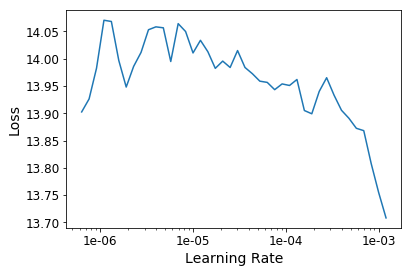

In [113]:
learn.recorder.plot()

In [114]:
learn.fit_one_cycle(1, 1e-04, wd=0.2)

epoch,train_loss,valid_loss,exp_rmspe
1,inf,nan,nan


In [ ]:
learn.save('1')

In [ ]:
learn.recorder.plot_losses(last=-1)

TypeError: ignored